In [1]:
### all csv files used in this notebook are made in ../notebooks/sit_new_product.ipynb

In [2]:
import pandas as pd
import numpy as np
import itertools
import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

### load buoy and auxiliary data

In [3]:
moorings = ['sumata','a','b','d']

### calculate correlation and bias between mooring and cs2 anoms, over fyi and myi

In [4]:
thresholds =  np.arange(5,96,2.5)
alphas = np.round(np.arange(0,1.01,0.01),decimals=2)

In [5]:
rho_fyi = 916.7
rho_myi = 882.0

In [6]:
data_name = 'era5'

In [7]:
cryo_dir = f'/Users/carmennab/Dropbox/alpha_retracker/data/sit/pysiral/alpha_sits_{data_name}'

r_values_dictionary_all = {} ; bias_dictionary_all = {} 

iterator = list(itertools.product(thresholds,alphas))

all_moorings = ['sumata','a','b','d']
aoo_moorings = ['sumata']
bgep_moorings = ['a','b','d']

for mooring_name, moorings in zip(['AOO','BGEP','Combined'],[aoo_moorings,bgep_moorings,all_moorings]):
    r_values_dictionary = {} ; bias_dictionary = {} ; slope_dictionary = {}

    for threshold, alpha in tqdm.tqdm(iterator):

        values = [] 

        for mooring in moorings:

            cryosat_df = pd.read_csv(f'{cryo_dir}/a{alpha}_{mooring}.csv')

            for month, year in zip(cryosat_df['month'],cryosat_df['year']):

                df_cs2_mon_year = cryosat_df[(cryosat_df['month']==month) & (cryosat_df['year']==year)]

                cs2_value = df_cs2_mon_year[f'mean_sit_{threshold}'].iloc[0]
                mooring_value = df_cs2_mon_year['mean_buoy_thickness'].iloc[0]

                values.append({"year":year,"month":month,"cryosat_thickness":cs2_value,
                                "mooring_thickness":mooring_value,"mooring":mooring})

        values_df = pd.DataFrame(values)


        df_anoms = {} ; mooring_anoms = [] ; cryosat_anoms = []
        for mooring in moorings: ### calculate anoms for each mooring 

            mooring_df = values_df[values_df['mooring']==mooring]

            months = set(mooring_df['month'])

            mooring_climatologies = {} ; cryosat_climatologies = {}

            for month in months:
                df_cs2_mon = mooring_df['cryosat_thickness'][mooring_df['month']==month]
                df_mooring_mon = mooring_df['mooring_thickness'][mooring_df['month']==month]

                cryosat_climatologies[month] = np.nanmean(df_cs2_mon)
                mooring_climatologies[month] = np.nanmean(df_mooring_mon)

            monthly_bias = []

            for month, cs2_sit, mooring_sit in zip(mooring_df['month'],mooring_df['cryosat_thickness'],
                                                   mooring_df['mooring_thickness']):
                mooring_anoms.append(mooring_sit-mooring_climatologies[month])
                cryosat_anoms.append(cs2_sit-cryosat_climatologies[month])
                monthly_bias.append(cs2_sit-mooring_sit)

        df_anoms['mooring_anom'] = mooring_anoms ### combine anoms from moorings into one dataframe
        df_anoms['cryosat_anom'] = cryosat_anoms

        c = np.array(df_anoms['cryosat_anom']) ### calculate correlation between moorings and cs2
        m = np.array(df_anoms['mooring_anom'])
        df = pd.DataFrame({'c':c,'m':m}).dropna()

        if (threshold == 5) & (alpha == 0):
            print(mooring_name,len(df['m']))

        x = df['m']
        y = df['c']
        
        rmse = np.sqrt(np.nanmean((x-y)**2))

        r_values_dictionary[(threshold,alpha)] = rmse
        bias_dictionary[(threshold,alpha)] = np.nanmean(monthly_bias)

    r_values_dictionary_all[mooring_name] = r_values_dictionary
    bias_dictionary_all[mooring_name] = bias_dictionary

  0%|                                          | 9/3737 [00:00<01:22, 45.43it/s]

AOO 63


  0%|                                          | 2/3737 [00:00<04:18, 14.45it/s]

BGEP 216


  0%|                                          | 2/3737 [00:00<05:07, 12.15it/s]

Combined 279


100%|███████████████████████████████████████| 3737/3737 [05:02<00:00, 12.33it/s]


In [8]:
r_values_dict = {} ; biases_dict = {} 

for mooring_name in ['AOO','BGEP','Combined']:

    r_values_dictionary = r_values_dictionary_all[mooring_name]
    bias_dictionary = bias_dictionary_all[mooring_name]

    r_values_matrix = np.full((len(thresholds),len(alphas)),np.nan)
    bias_matrix = np.full((len(thresholds),len(alphas)),np.nan)

    for tcounter, thresh in enumerate(thresholds):

        for acounter, alpha in enumerate(alphas):

            r_val = r_values_dictionary[(thresh,alpha)] 
            bias = bias_dictionary[(thresh,alpha)] 

            r_values_matrix[tcounter,acounter] = r_val
            bias_matrix[tcounter,acounter] = bias

    r_values_dict[mooring_name] = r_values_matrix
    biases_dict[mooring_name] = bias_matrix

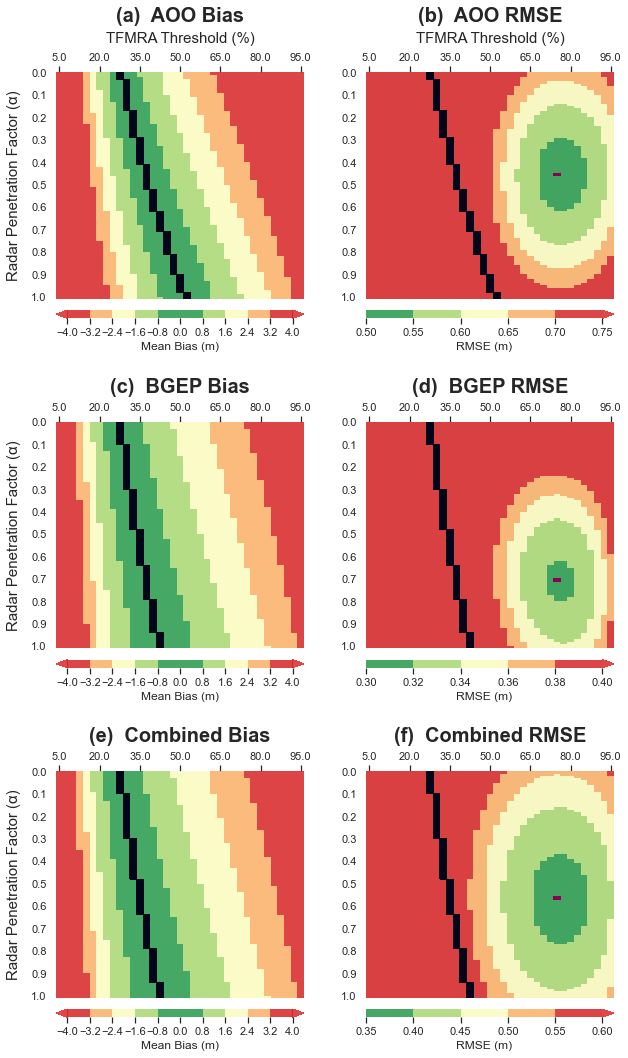

In [11]:
### plot figure
fig = plt.figure(figsize=(10,18))
spec = gridspec.GridSpec(ncols=2, nrows=3,wspace=0.25,hspace=0.25)
plt.rc('font', size=10)
plt.rcParams.update({'hatch.color': 'black'})
sns.set(rc={'axes.facecolor':'#f0f0f0'})
nums = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ']

a00_ticks_r = [0.5,0.55,0.6,0.65,0.7,0.75]
bgep_ticks_r = [0.3,0.32,0.34,0.36,0.38,0.4]
combined_ticks_r = [0.35,0.4,0.45,0.5,0.55,0.6,0.65]
xtick_labels = [5,20,35,50,65,80,95]

k = 0
for mooring_name,limit_r,ticks_r in zip(['AOO','BGEP','Combined'],[[0.5,0.75],[0.3,0.4],
    [0.35,0.6]],[a00_ticks_r,bgep_ticks_r,combined_ticks_r]):

    ### bias heatmap
    bias_df = pd.DataFrame(biases_dict[mooring_name].T,columns=thresholds,index=alphas)
    ax1 = fig.add_subplot(spec[k])
    list_colors = ['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641','#1a9641','#a6d96a','#ffffbf','#fdae61','#d7191c']
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 10)
    bias_ticks = [-4,-3.2,-2.4,-1.6,-0.8,0,0.8,1.6,2.4,3.2,4]
    label = 'Mean Bias (m)'
    ax1 = sns.heatmap(bias_df, cmap=cm, annot=False, vmin=-4,vmax=4,yticklabels=10,cbar=True,alpha=0.8,
                      xticklabels=6,cbar_kws={'location': 'bottom','extend': 'both',"ticks":bias_ticks,"aspect":30,
                                              "label":label,"pad": 0.04})
    ### calculate mins line

    mins = np.full((biases_dict[mooring_name].T.shape),np.nan)

    for alpha in np.arange(0,len(mins)):
        min = np.nanargmin(np.abs(biases_dict[mooring_name][:,alpha]))
        mins[alpha,min] = 1

    x = np.arange(0,len(thresholds)+1)
    y = np.arange(0,len(alphas)+1)

    ax1.pcolor(x, y, mins)

    ax1.tick_params(axis='y', labelrotation=0)
    if k==0:
        ax1.set_xlabel('TFMRA Threshold (%)',labelpad=10,fontsize=15)
    ax1.set_ylabel('Radar Penetration Factor (\u03B1)',labelpad=10,fontsize=15)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_title(f'{nums[k]} {mooring_name} Bias',fontweight='bold',fontsize=20,pad=10)

    k+=1

    ### correlation 
    rs_df = pd.DataFrame(r_values_dict[mooring_name].T,columns=thresholds,index=alphas)
    ax2 = fig.add_subplot(spec[k])
    list_colors = ['#1a9641','#a6d96a','#ffffbf','#fdae61','#d7191c'] 
    
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 5)
    list_colors_mask = ['gainsboro','gainsboro'] 
    cm_mask = LinearSegmentedColormap.from_list('map', list_colors_mask, N = 2)
    mask = r_values_dict[mooring_name].T.copy()
    mask[np.isnan(mask)] = 1000
    mask[mask<1000] = 0
    label = 'RMSE (m)'
    ax2 = sns.heatmap(rs_df, cmap=cm_mask, annot=False, annot_kws={'color': 'k'},fmt=".2f", 
                      xticklabels=10,cbar=False,)

    ax2 = sns.heatmap(rs_df, cmap=cm, mask=mask,annot=False, linewidths=0,cbar=True, alpha=0.8,vmin=limit_r[0],
                      vmax=limit_r[1],yticklabels=10,xticklabels=6,cbar_kws={'location': 'bottom','extend': 'max',
                      "aspect":30,"label":label,"pad": 0.04,"ticks": ticks_r})

    ### plot min line
    ax2.pcolor(x, y, mins)

    ax2.tick_params(axis='y', labelrotation=0)
    if k==1:
        ax2.set_xlabel('TFMRA Threshold (%)',labelpad=10,fontsize=15)
#     ax2.set_ylabel('Radar Penetration Factor (\u03B1)',labelpad=10,fontsize=15)

    ### calculate lowest rmse
    min = r_values_dict[mooring_name].T.copy()
    mi = np.nanmin(r_values_dict[mooring_name])
    min[min>mi] = np.nan
    min[min==mi] = 1
    
    ax2.pcolor(x, y, min,cmap='PiYG')

    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.set_title(f'{nums[k]} {mooring_name} RMSE',fontweight='bold',fontsize=20,pad=10)

    k+=1

figpath = f'/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/main_figs/bias_corr.jpg'
plt.savefig(figpath,bbox_inches = "tight", dpi = 400)